In [ ]:
# Standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 5.  Improving model predictions through experimentation (hyperparameter tuning)

The first predictions you make with a model are generally referred to as baseline predictions. The same goes with the first evaluation metrics you get. These are generally referred to as baseline metrics.

Your next goal is to improve upon these baseline metrics.

Two of the main methods to improve baseline metrics are from a data perspective and a model perspective.

From a data perspective asks:
* Could we collect more data? In machine learning, more data is generally better, as it gives a model more opportunities to learn patterns.
* Could we improve our data? This could mean filling in misisng values or finding a better encoding (turning things into numbers) strategy.

From a model perspective asks:
* Is there a better model we could use? If you've started out with a simple model, could you use a more complex one? (we saw an example of this when looking at the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), ensemble methods are generally considered more complex models)
* Could we improve the current model? If the model you're using performs well straight out of the box, can the **hyperparameters** be tuned to make it even better?

**Note:** Patterns in data are also often referred to as data parameters. The difference between parameters and hyperparameters is a machine learning model seeks to find parameters in data on its own, where as, hyperparameters are settings on a model which a user (you) can adjust.

Since we have two existing datasets, we'll come at exploration from a model perspective.

More specifically, we'll look at how we could improve our `RandomForestClassifier` and `RandomForestRegressor` models through hyperparameter tuning.

What even are hyperparameters?

Good question, let's check it out. First, we'll instantiate a `RandomForestClassifier`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

When you instantiate a model like above, you're using the default hyperparameters.

These get printed out when you call the model instance and `get_params()`.

In [ ]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

You'll see things like `max_depth`, `min_samples_split`, `n_estimators`.

Each of these is a hyperparameter of the `RandomForestClassifier` you can adjust. 

You can think of hyperparameters as being similar to dials on an oven. On the default setting your oven might do an okay job cooking your favourite meal. But with a little experimentation, you find it does better when you adjust the settings. 

<img src="../images/sklearn-hyperparameter-tuning-oven.png" width=600/>

The same goes for imporving a machine learning model by hyperparameter tuning. The default hyperparameters on a machine learning model may find patterns in data well. But there's a chance a adjusting the hyperparameters may improve a models performance.

Every machine learning model will have different hyperparameters you can tune.

You might be thinking, "how the hell do I remember all of these?"

And it's a good question. It's why we're focused on the Random Forest. Instead of memorizing all of the hyperparameters for every model, we'll see how it's done with one. And then knowing these principles, you can apply them to a different model if needed.

Reading the [Scikit-Learn documentation for the Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), you'll find they suggest trying to change `n_estimators` (the number of trees in the forest) and `min_samples_split` (the minimum number of samples required to split an internal node).

We'll try tuning these as well as:
* `max_features` (the number of features to consider when looking for the best split)
* `max_depth` (the maximum depth of the tree)
* `min_samples_leaf` (the minimum number of samples required to be at a leaf node)

If this still sounds like a lot, the good news is, the process we're taking with the Random Forest and tuning its hyperparameters, can be used for other machine learning models in Scikit-Learn. The only difference is, with a different model, the hyperparameters you tune will be different.

Adjusting hyperparameters is usually an experimental process to figure out which are best. As there's no real way of knowing which hyperparameters will be best when starting out.

To get familar with hyparameter tuning, we'll take our RandomForestClassifier and adjust its hyperparameters in 3 ways.

1. By hand
2. Randomly with [RandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
3. Exhaustively with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### 5.1 Tuning hyperparameters by hand 

So far we've worked with training and test datasets.

You train a model on a training set and evaluate it on a test dataset.

But hyperparameter tuning introduces a thrid set, a validation set.

Now the process becomes, train a model on the training data, (try to) improve its hyperparameters on the validation set and evaluate it on the test set.

If our starting dataset contained 100 different patient records labels indicating who had heart disease and who didn't and we wanted to build a machine learning model to predict who had heart disease and who didn't, it might look like this:

<img src="../images/sklearn-train-valid-test-annotated.png" width=500/>

<img src="../images/validation-split.png" width=600/>

Since we know we're using a `RandomForestClassifier` and we know the hyperparameters we want to adjust, let's see what it looks like.

First, let's remind ourselves of the base parameters.

In [ ]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

And we're going to adjust:
* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_samples_split`
* `n_estimators`

We'll use the same code as before, except this time we'll create a training, validation and test split.

With the training set containing 70% of the data and the validation and test sets each containing 15%.

Let's get some baseline results, then we'll tune the model.

And since we're going to be evaluating a few models, let's make an evaluation function.

In [ ]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

# Shuffle the data
heart_disease = heart_disease.sample(frac=1)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split the data into train, validation & test sets
train_split = round(0.7 * len(heart_disease)) # 70% of data
valid_split = round(train_split + 0.15 * len(heart_disease)) # 15% of data
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[valid_split:]

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_valid)

# Evaluate the classifier
baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Acc: 82.22%
Precision: 0.81
Recall: 0.88
F1 score: 0.85


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.88, 'f1': 0.85}

Beautiful, now let's try and improve the results.

We'll change 1 of the hyperparameters, `n_estimators` to 100 and see if it improves on the validation set.

In [ ]:
np.random.seed(42)

# Create a second classifier
clf_2 = RandomForestClassifier(n_estimators=100)
clf_2.fit(X_train, y_train)

# Make predictions
y_preds_2 = clf_2.predict(X_valid)

# Evaluate the 2nd classifier
clf_2_metrics = evaluate_preds(y_valid, y_preds_2)

Acc: 82.22%
Precision: 0.84
Recall: 0.84
F1 score: 0.84


Not bad! Slightly worse precision by slightly better recall and f1.

How about we try another parameter?

Wait...

This could take a while if all we're doing is building new models with new hyperparameters each time.

Surely there's a better way?

There is.

### 5.2 Hyperparameter tuning with [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) allows us to randomly search across different hyperparameters to see which work best. It also stores details about the ones which work best!

Let's see it in action.

First, we create a grid (dictionary) of hyperparameters we'd like to search over.

In [ ]:
# Hyperparameter grid RandomizedSearchCV will search over
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

Where did these values come from?

They're made up.

Made up?

Yes. Not completely pulled out of the air but after reading the [Scikit-Learn documentation on Random Forest's](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) you'll see some of these values have certain values which usually perform well and certain hyperparameters take strings rather than integers.

Now we've got the grid setup, Scikit-Learn's `RandomizedSearchCV` will look at it, pick a random value from each, instantiate a model with those values and test each model.

How many models will it test?

As many as there are for each combination of hyperparameters to be tested. Let's add them up.

`max_depth` has 4, `max_features` has 2, `min_samples_leaf` has 3, `min_samples_split` has 3, `n_estimators` has 5. That's 4x2x3x3x5 = 360 models!

Or...

We can set the `n_iter` parameter to limit the number of models `RandomizedSearchCV` tests.

The best thing? The results we get will be cross-validated (hence the CV in `RandomizedSearchCV`) so we can use `train_test_split()`.

And since we're going over so many different models, we'll set `n_jobs` to -1 of [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) so Scikit-Learn takes advantage of all the cores (processors) on our computers.

Let's see it in action.

**Note:** Depending on `n_iter` (how many models you test), the different values in the hyperparameter grid, and the power of your computer, running the cell below may take a while.

**Note 2:** Setting `n_jobs=-1` seems to be breaking on some machines (for me at least, as of 8 December 2019). There seems to be an issue about it, being tracked on GitHub. For the timebeing, `n_jobs=1` seems to be working.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all cores (NOTE: n_jobs=-1 is broken as of 8 Dec 2019, using n_jobs=1 works)
clf = RandomForestClassifier(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid,
                            n_iter=20, # try 20 models total
                            cv=5, # 5-fold cross-validation
                            verbose=2) # print out results

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10

When `RandomizedSearchCV` goes through `n_iter` combinations of of hyperparameter search space, it stores the best ones in the attribute `best_params_`.

In [ ]:
# Find the best hyperparameters found by RandomizedSearchCV
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10}

Now when we call `predict()` on `rs_clf` (our `RandomizedSearchCV` version of our classifier), it'll use the best hyperparameters it found.

In [ ]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


Excellent! Thanks to `RandomizedSearchCV` testing out a bunch of different hyperparameters, we get a nice boost to all of the evaluation metrics for our classification model.

There's one more way we could try to improve our model's hyperparamters. And it's with [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### 5.3 Hyperparameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

The main difference between `GridSearchCV` and `RandomizedSearchCV` is `GridSearchCV` searches across a grid of hyperparamters exhaustively, where as, `RandomizedSearchCV` searches across a grid of hyperparameters randomly (stopping after `n_iter` combinations).

For example, let's see our grid of hyperparameters.

In [ ]:
grid

{'n_estimators': [10, 100, 200, 500, 1000, 1200],
 'max_depth': [None, 5, 10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 4, 6],
 'min_samples_leaf': [1, 2, 4]}

`RandomizedSearchCV` try `n_iter` combinations of different values. Where as, `GridSearchCV` will try every single possible combination. 

And if you remember from before when we did the calculation: `max_depth` has 4, `max_features` has 2, `min_samples_leaf` has 3, `min_samples_split` has 3, `n_estimators` has 5. 

That's 4x2x3x3x5 = 360 models!

This could take a long time depending on the power of the computer you're using, the amount of data you have and the complexity of the hyperparamters (usually higher values means a more complex model).

In our case, the data we're using is relatively small (only ~300 samples).

Since we've already tried to find some ideal hyperparameters using `RandomizedSearchCV`, we'll create another hyperparameter grid based on the `best_params_` of `rs_clf`* with less options and then try to use `GridSearchCV` to find a more ideal set.

**Note:** Based on the `best_params_` of `rs_clf` implies the next set of hyperparameters we'll try are roughly in the same range of the best set found by `RandomizedSearchCV`.

In [ ]:
# Another hyperparameter grid similar to rs_clf.best_params_
grid_2 = {'n_estimators': [1200, 1500, 2000],
          'max_depth': [None, 5, 10],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [4, 6],
          'min_samples_leaf': [1, 2]}

We've created another grid of hyperparameters to search over, this time with less total.

`n_estimators` has 3, `max_depth` has 3, `max_features` has 2, `min_samples_leaf` has 2, `min_samples_split` has 2. 

That's 3x3x2x2x2 = 72 models in total. Or about 5 times less (360/72) combinations of hyperparameters less than our original grid.

Now when we run `GridSearchCV`, passing it our classifier (`clf`), paramter grid (`grid_2`) and the number of cross-validation folds we'd like to use (`cv`), it'll create a model with every single combination of hyperparameters, 72 in total, and check the results.

In [ ]:
# from sklearn.model_selection import GridSearchCV, train_test_split

# np.random.seed(42)

# # Split into X & y
# X = heart_disease.drop("target", axis=1)
# y = heart_disease["target"]

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Set n_jobs to -1 to use all cores (NOTE: n_jobs=-1 is broken as of 8 Dec 2019, using n_jobs=1 works)
# clf = RandomForestClassifier(n_jobs=1)

# # Setup GridSearchCV
# gs_clf = GridSearchCV(estimator=clf,
#                       param_grid=grid_2,
#                       cv=5, # 5-fold cross-validation
#                       verbose=2) # print out progress

# # Fit the RandomizedSearchCV version of clf
# gs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_s

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_dep

[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.9s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1500; total time=   1.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1500; total time=   1.0s
[CV] END max_depth=5, max_features=auto,

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=2000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=2000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=2000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=2000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=2000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt,

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   0.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500; total time=   1.0s
[CV] END max_depth=10, max_featu

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   0.8s
[CV] END max_depth=10, max_featu

Once it completes, we can check the best hyperparameter combinations it found using the `best_params_` attribute.

In [ ]:
# Check the best hyperparameters found with GridSearchCV
# gs_clf.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 1200}

And by default when we call the `predict()` function on `gs_clf`, it'll use the best hyperparameters.

In [ ]:
# Max predictions with the GridSearchCV classifier
# gs_y_preds = gs_clf.predict(X_test)

# Evaluate the predictions
# gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


Let's create a DataFrame to compare the different metrics. 

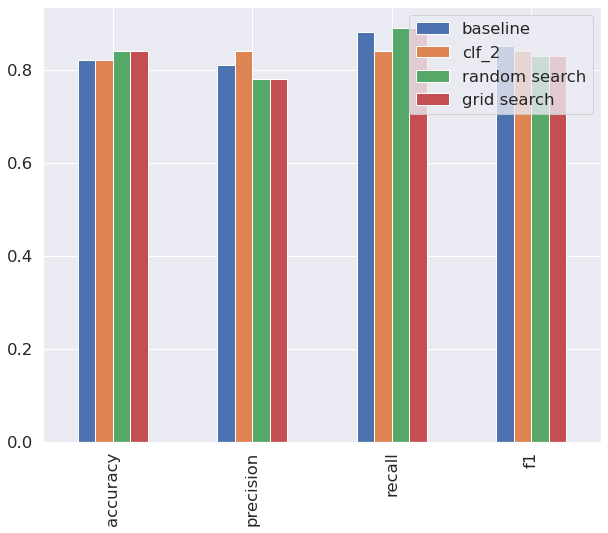

In [ ]:
# compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
#                                 "clf_2": clf_2_metrics,
#                                 "random search": rs_metrics,
#                                 "grid search": gs_metrics})
# compare_metrics.plot.bar(figsize=(10, 8));

It seems, even after trying 72 different combinations of hyperparamters, we don't get an improvement in results.

These things might happen. But it's important to remember, it's not over. There may be more we can do.

In a hyperparameter tuning sense, there may be a better set we could find through more extensive searching with RandomizedSearchCV and GridSearchCV but it's likely these improvements will be marginal.

A few next ideas you could try:
* Collecting more data - Based on the results our models are getting now, it seems like they're finding some patterns. Collecting more data may improve a models ability to find patterns. However, your ability to do this will largely depend on the project you're working on.
* Try a more advanced model - Although our tuned Random Forest model is doing pretty well, a more advanced ensemble method such as [XGBoost](https://xgboost.ai/) or [CatBoost](https://catboost.ai/) might perform better.

Since machine learning is part engineering, part science, these kind of experiments are common place in any machine learning project.

Now you've got a somewhat tuned Random Forest model, the next thing you might want to do is export it and save it so you could share it with your team or use it in an application without having to retrain it.